### import des librairies

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.feature_selection import SelectKBest,chi2
import statsmodels
from sklearn.impute import KNNImputer
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import RFE,RFECV
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, validation_curve,learning_curve
from sklearn.linear_model import SGDRegressor, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score, f1_score , mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler,OneHotEncoder,RobustScaler, OrdinalEncoder,PowerTransformer,PolynomialFeatures
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.svm import SVR
from scipy import spatial,stats
from scipy.stats import kstest
import folium
import warnings
warnings.filterwarnings('ignore')

# Partie prédiction

## Prédiction de la consommation annuelle d'énergie (SiteEnergyUseWN)

In [69]:
df2 = df2.reset_index(drop=True)

In [70]:
y = df2.copy()['SiteEnergyUseWN(kBtu)']
X = df2.copy().drop(['SiteEnergyUseWN(kBtu)','TotalGHGEmissions',"Electricity(kBtu)","NaturalGas(kBtu)"], axis=1)
categorical_columns = X.select_dtypes(['category','object'])
numerical_columns = X.select_dtypes(['int64','float64'])

In [71]:
ordinal = OrdinalEncoder()

col_cat_encoded = ordinal.fit_transform(categorical_columns)
col_cat_encoded = pd.DataFrame(col_cat_encoded, columns=categorical_columns.columns)
X = pd.concat([numerical_columns,col_cat_encoded ], axis=1)


In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.25,random_state = 42)

In [73]:
X.shape

(1334, 16)

In [74]:
y.shape

(1334,)

In [75]:
print(X_train.isna().sum().sum())
print(X_test.isna().sum().sum())
print(y_train.isna().sum().sum())
print(y_test.isna().sum().sum())

0
0
0
0


### DummyRegressor après Standardscaler

In [76]:
pipe = make_pipeline(StandardScaler(), DummyRegressor())

In [77]:
model = pipe.fit(X_train, y_train)

In [78]:
print('Score test  : ',model.score(X_test, y_test))
print('Score train : ',model.score(X_train, y_train))

Score test  :  -0.014283291979036994
Score train :  0.0


### LinearRegression avec Standardscaler

In [79]:
pipe = make_pipeline(StandardScaler(), LinearRegression())

In [80]:
model = pipe.fit(X_train, y_train)

In [81]:
print('Score test  : ',model.score(X_test, y_test))
print('Score train : ',model.score(X_train, y_train))

Score test  :  0.7423277812005475
Score train :  0.5955962324931522


### DummyRegressor avec RobustScaler

In [82]:
df2 = df2.reset_index(drop=True)

In [83]:
y = df2.copy()['SiteEnergyUseWN(kBtu)']
X = df2.copy().drop(['SiteEnergyUseWN(kBtu)','TotalGHGEmissions',"Electricity(kBtu)","NaturalGas(kBtu)"], axis=1)
categorical_columns = X.select_dtypes(['category','object'])
numerical_columns = X.select_dtypes(['int64','float64'])

In [84]:
ordinal = OrdinalEncoder()

col_cat_encoded = ordinal.fit_transform(categorical_columns)
col_cat_encoded = pd.DataFrame(col_cat_encoded, columns=categorical_columns.columns)
X = pd.concat([numerical_columns,col_cat_encoded ], axis=1)


In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.25,random_state = 42)

In [86]:
pipe = make_pipeline(RobustScaler(), DummyRegressor())

In [87]:
model = pipe.fit(X_train, y_train)

In [88]:
print('Score test  : ',model.score(X_test, y_test))
print('Score train : ',model.score(X_train, y_train))

Score test  :  -0.014283291979036994
Score train :  0.0


### LinearRegression avec RobustScaler

In [89]:
pipe = make_pipeline(RobustScaler(), LinearRegression())

In [90]:
model = pipe.fit(X_train, y_train)

In [91]:
print('Score test  : ',model.score(X_test, y_test))
print('Score train : ',model.score(X_train, y_train))

Score test  :  0.7423277812045366
Score train :  0.5955962324931523


SUR LES RESULTATS OBTENUES DANS LINEARREGRESSION , LEs SCORES SONT IDENTIQUES AVEC UN PASSAGE DANS ROBUSTSCALER ET DANS STANDARDSCALER . NOUS ALLONS DONC TRAVAILLER AVEC ORDINALENCODER ET ROBUSTSCALER ET TESTER LES MODELES SANS CV PUIS AVEC RANDOMIZEDSEARCHCV ET GRIDSEARCHCV

### Modélisation de plusieurs modèles

In [92]:
new_df = df2.copy()

In [93]:
y = new_df['SiteEnergyUseWN(kBtu)']
X = new_df.drop(['SiteEnergyUseWN(kBtu)','TotalGHGEmissions',"Electricity(kBtu)","NaturalGas(kBtu)"], axis=1)
categorical_columns = X.select_dtypes(['category','object']).columns.tolist()
numerical_columns = X.select_dtypes(['int64','float64']).columns.tolist()

In [94]:

column_transformer = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_columns),
        ('cat', OrdinalEncoder(), categorical_columns)
    ],
    remainder='passthrough')


In [95]:
pipeline = Pipeline([
    ('column_transform', column_transformer)
])

X= pipeline.fit_transform(X)


### Passage dans PowerTransform pour plus normalisé les données afin d'améliorer notre résultat

In [96]:
pt = PowerTransformer()
X= pt.fit_transform(X)


In [97]:

X = pd.DataFrame(X, columns=numerical_columns + categorical_columns)
X

,OSEBuildingID,DataYear,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,ENERGYSTARScore,SourceEUI(kBtu/sf),SteamUse(kBtu),BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,LargestPropertyUseType
0,-1.400009,0.0,0.034520,-0.028133,-1.034142,0.05244,2.086677,0.987444,-1.546863,0.429093,-0.186844,-0.231040,-1.169739,1.224761,-0.818371,-0.760356
1,-1.398639,0.0,-1.445564,2.720835,-0.033746,0.05244,-0.106355,0.465771,1.556163,-0.832124,-0.186844,2.746108,-1.655990,-0.970059,1.777716,-1.674331
2,-1.398563,0.0,0.908314,0.595443,1.336749,0.05244,1.434264,1.061813,0.809600,0.443196,-0.186844,-0.231040,-1.169739,0.091775,1.195875,-0.760356
3,-1.398411,0.0,0.056632,0.052646,-0.926985,0.05244,-0.106355,0.722249,-0.224383,-0.822164,-0.186844,-0.231040,0.015339,1.224761,-0.818371,1.793325
4,-1.398182,0.0,0.208887,1.104696,-0.216883,0.05244,-1.214694,1.412947,-0.224383,-2.274072,-0.186844,2.746108,-1.655990,-0.389172,-1.673004,-1.674331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1329,2.557330,0.0,-1.563315,-1.604818,0.655475,0.05244,-1.214694,-1.642583,-0.224383,0.203285,-0.186844,1.781773,0.015339,-1.748768,-1.224536,-0.337346
1330,2.557411,0.0,-0.958907,0.847306,0.936199,0.05244,-1.214694,-2.254310,-0.973477,0.574208,-0.186844,1.781773,-0.156717,-0.970059,-0.085144,0.271123
1331,2.557493,0.0,-0.329146,0.376963,1.448756,0.05244,-1.214694,-1.863664,-0.224383,0.055388,-0.186844,1.781773,0.015339,-0.970059,-0.818371,-0.337346
1332,2.557655,0.0,-1.852451,0.316243,0.900606,0.05244,-1.214694,-2.059384,-0.224383,-0.067266,-0.186844,1.781773,-0.328008,-1.748768,-0.085144,-0.337346


In [98]:
X.shape

(1334, 16)

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.25,random_state = 42)

In [100]:
X_train.shape


(1000, 16)

In [101]:
X_test.shape


(334, 16)

In [102]:
y_train.shape


(1000,)

In [103]:

y_test.shape

(334,)

### Définition des meilleurs hyper paramètres

In [104]:
models = [
    ('LinearRegression', LinearRegression(), {'normalize': [True, False]}),
    ('gboost', GradientBoostingRegressor(), {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2]
    }),
    ('rfr', RandomForestRegressor(), {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }),
    ('KNeighborsRegressor', KNeighborsRegressor(), {'n_neighbors': [3, 5, 7]}),
    ('SVR', SVR(), {
        'kernel': ['linear', 'poly', 'rbf'],
        'C': [0.1, 1, 10],
        'epsilon': [0.01, 0.1, 0.2]
    }),
    ('ElasticNet', ElasticNet(), {
        'alpha': [0.01, 0.1, 1.0],
        'l1_ratio': [0.1, 0.5, 0.9],
        'normalize': [True, False]
    })
]

best_params = {}

for model_name, model, param_grid in models:
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_params[model_name] = grid_search.best_params_


In [105]:
best_params

{'LinearRegression': {'normalize': False},
 'gboost': {'learning_rate': 0.2, 'n_estimators': 50},
 'rfr': {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 50},
 'KNeighborsRegressor': {'n_neighbors': 7},
 'SVR': {'C': 10, 'epsilon': 0.01, 'kernel': 'linear'},
 'ElasticNet': {'alpha': 0.1, 'l1_ratio': 0.9, 'normalize': False}}

In [106]:
models = [
    ('Dummy Regressor', DummyRegressor(), {'strategy' : ['mean']}),  
    ('Linear Regression', LinearRegression(), {'fit_intercept': [True, False], 'normalize': [True, False], 'copy_X': [True]}),
    ('Elastic Net', ElasticNet(), {'alpha': [1,0.1,0.01,0.001], 'max_iter': [1000], 'random_state': [42], 'tol': [0.001]}),
    ('K-Neighbors Regressor', KNeighborsRegressor(), {'n_neighbors': list(range(1,30))}),
    ('SVR', SVR(), {'gamma' : ['scale'],'epsilon' : [0.001, 0.01, 0.1, 1],'C' : [0.001, 0.01, 0.1, 1, 10], 'tol':[0.001]}),
    ('Random Forest Regressor', RandomForestRegressor(), {'n_estimators': [100, 500, 1000], 'max_features': ['auto'], 'n_jobs': [-1], 
              'random_state': [42], 'max_depth': [None]}),
    ('Gradient Boosting Regressor', GradientBoostingRegressor(), 
     {'n_estimators':[100, 500, 1000], 'random_state': [42], 'max_depth': [None]})
]


In [107]:
results = []

for model_name, model, param_grid in models:
   
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    train_r2 = r2_score(y_train, model.predict(X_train))
    test_r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    med_abs_error= round(median_absolute_error(y_test, y_pred),2)
    elapsed_time = time.time() - start_time
    results.append([model_name, 'No CV', train_r2, test_r2, rmse, med_abs_error, elapsed_time])

   
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    train_r2 = r2_score(y_train, best_model.predict(X_train))
    test_r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    med_abs_error= round(median_absolute_error(y_test, y_pred),2)
    elapsed_time = time.time() - start_time
    results.append([model_name, 'GridSearchCV', train_r2, test_r2, rmse,med_abs_error, elapsed_time])

  
    randomized_search = RandomizedSearchCV(model, param_grid, n_iter=5, cv=5, n_jobs=-1)
    start_time = time.time()
    randomized_search.fit(X_train, y_train)
    best_model = randomized_search.best_estimator_
    y_pred = best_model.predict(X_test)
    train_r2 = r2_score(y_train, best_model.predict(X_train))
    test_r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    med_abs_error= round(median_absolute_error(y_test, y_pred),2)
    elapsed_time = time.time() - start_time
    results.append([model_name, 'RandomizedSearchCV', train_r2, test_r2, rmse,med_abs_error, elapsed_time])

results_df = pd.DataFrame(results, columns=['Model', 'CV Type', 'Train R2', 'Test R2', 'RMSE','Median absolute error',
                                            'Elapsed Time'])

results_df



,Model,CV Type,Train R2,Test R2,RMSE,Median absolute error,Elapsed Time
0,Dummy Regressor,No CV,0.000000,-0.014283,3.129338e+06,1635811.25,0.002013
1,Dummy Regressor,GridSearchCV,0.000000,-0.014283,3.129338e+06,1635811.25,0.013438
2,Dummy Regressor,RandomizedSearchCV,0.000000,-0.014283,3.129338e+06,1635811.25,0.012005
3,Linear Regression,No CV,0.655508,0.692243,1.723761e+06,808370.56,0.004999
4,Linear Regression,GridSearchCV,0.655508,0.692243,1.723761e+06,808370.56,0.043006
5,Linear Regression,RandomizedSearchCV,0.655508,0.692243,1.723761e+06,808370.56,0.042513
6,Elastic Net,No CV,0.588697,0.592747,1.982920e+06,709323.01,0.005000
7,Elastic Net,GridSearchCV,0.653474,0.683274,1.748699e+06,750251.94,0.044312
8,Elastic Net,RandomizedSearchCV,0.653474,0.683274,1.748699e+06,750251.94,0.044216
9,K-Neighbors Regressor,No CV,0.713692,0.643750,1.854600e+06,616081.53,0.031210


In [108]:
rfr = RandomForestRegressor(**best_params['rfr'])
rfr.fit(X_train, y_train)

RandomForestRegressor(min_samples_split=10, n_estimators=50)

#### Courbe d'apprentissage du modèle RandomForest

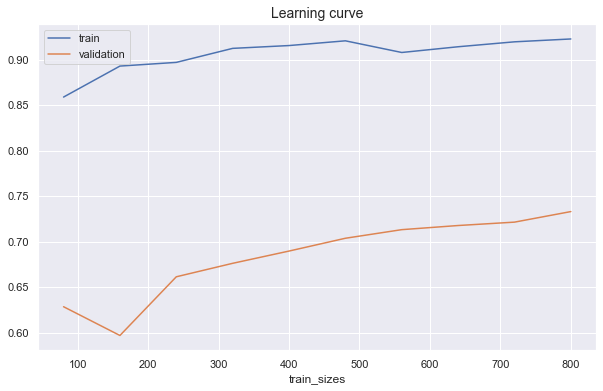

In [109]:
N,train_score,val_score = learning_curve(rfr,X_train,y_train,train_sizes = np.linspace(0.1,1.0,10))
plt.figure(figsize=(10, 6))
plt.plot(N,train_score.mean(axis=1),label='train')
plt.plot(N,val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.title('Learning curve', size = 14)
plt.legend()
plt.show()

#### Courbe de validation du modèle RandomForest

In [110]:
param_range = [50, 100, 150, 200, 250]  
train_scores, test_scores = validation_curve(
    rfr,  
    X_train, y_train,
    param_name="n_estimators",  
    param_range=param_range,
    cv=5,  
    scoring="r2",  
    n_jobs=-1  
)


In [111]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


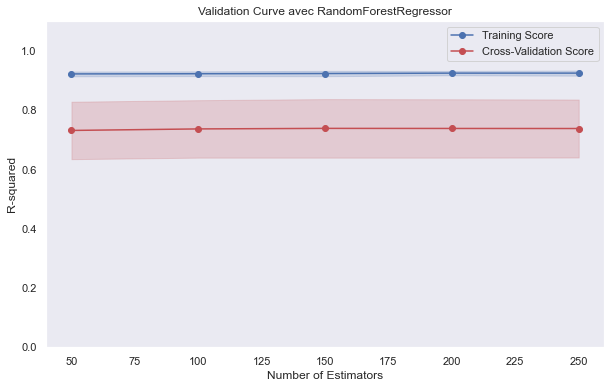

In [112]:
plt.figure(figsize=(10, 6))
plt.title("Validation Curve avec RandomForestRegressor")
plt.xlabel("Number of Estimators")
plt.ylabel("R-squared")
plt.ylim(0.0, 1.1)
plt.grid()

plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="b")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="r")
plt.plot(param_range, train_scores_mean, 'o-', color="b", label="Training Score")
plt.plot(param_range, test_scores_mean, 'o-', color="r", label="Cross-Validation Score")

plt.legend(loc="best")
plt.show()


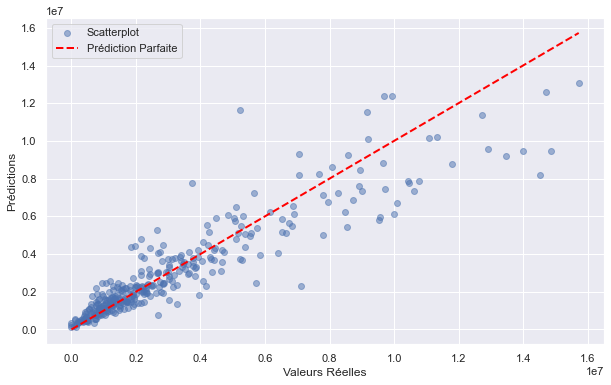

In [113]:
y_pred = rfr.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='b', label='Scatterplot')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--',
         linewidth=2, label='Prédiction Parfaite')
plt.xlabel('Valeurs Réelles')
plt.ylabel('Prédictions')
plt.legend(loc='upper left')

plt.show()


#### Features importance

In [114]:
feature_importance_rf = rfr.feature_importances_

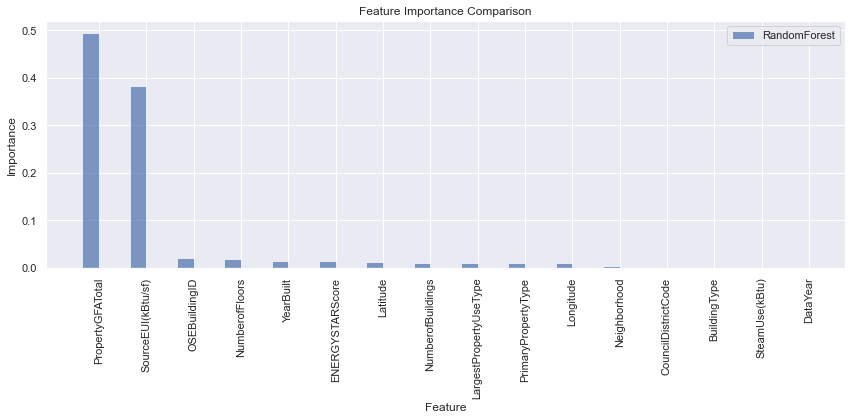

In [115]:
importance_df = pd.DataFrame({'Feature': X_train.columns, 'RandomForest': feature_importance_rf})

importance_df.sort_values(by='RandomForest', ascending=False, inplace=True)

bar_width = 0.35
index = np.arange(len(importance_df))

plt.figure(figsize=(12, 6))
plt.bar(index, importance_df['RandomForest'], bar_width, label='RandomForest', alpha=0.7)
plt.xticks(index + bar_width / 2, importance_df['Feature'], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.legend()
plt.title('Feature Importance Comparison')
plt.tight_layout()
plt.show()

In [116]:
pd.Series(rfr.feature_importances_*100, index=X_train.columns).nlargest(20)

PropertyGFATotal          49.565958
SourceEUI(kBtu/sf)        38.187775
OSEBuildingID              2.032886
NumberofFloors             1.786369
YearBuilt                  1.463598
ENERGYSTARScore            1.450977
Latitude                   1.172024
NumberofBuildings          0.959848
LargestPropertyUseType     0.953792
PrimaryPropertyType        0.906258
Longitude                  0.906180
Neighborhood               0.345897
CouncilDistrictCode        0.137077
BuildingType               0.103639
SteamUse(kBtu)             0.027722
DataYear                   0.000000
dtype: float64

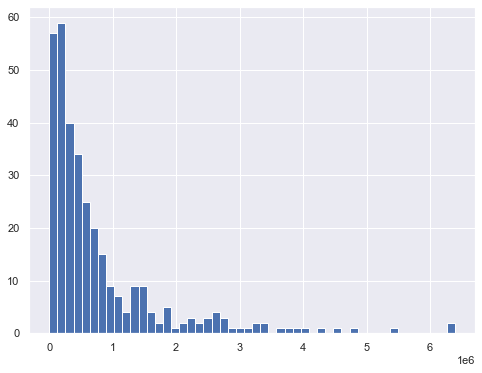

In [117]:
plt.figure(figsize=(8, 6))
y_pred = rfr.predict(X_test)
histo_erreur = np.abs(y_test - y_pred)
plt.hist(histo_erreur, bins= 50)
plt.show()

## Prédiction de la consommation d'energie sans avoir Energyscore dans les données

### Modélisation de plusieurs modèles

In [118]:
new_df = df2.copy()

In [119]:
y = new_df['SiteEnergyUseWN(kBtu)']
X = new_df.drop(['SiteEnergyUseWN(kBtu)','TotalGHGEmissions','ENERGYSTARScore',"Electricity(kBtu)","NaturalGas(kBtu)"], axis=1)
categorical_columns = X.select_dtypes(['category','object']).columns.tolist()
numerical_columns = X.select_dtypes(['int64','float64']).columns.tolist()

In [120]:

column_transformer = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_columns),
        ('cat', OrdinalEncoder(), categorical_columns)
    ],
    remainder='passthrough')


In [121]:
pipeline = Pipeline([
    ('column_transform', column_transformer)
])

X= pipeline.fit_transform(X)


### Passage dans PowerTransform pour plus normalisé les données afin d'améliorer notre résultat

In [122]:
pt = PowerTransformer()
X= pt.fit_transform(X)


In [123]:

X = pd.DataFrame(X, columns=numerical_columns + categorical_columns)
X

,OSEBuildingID,DataYear,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,SourceEUI(kBtu/sf),SteamUse(kBtu),BuildingType,PrimaryPropertyType,CouncilDistrictCode,Neighborhood,LargestPropertyUseType
0,-1.400009,0.0,0.034520,-0.028133,-1.034142,0.05244,2.086677,0.987444,0.429093,-0.186844,-0.231040,-1.169739,1.224761,-0.818371,-0.760356
1,-1.398639,0.0,-1.445564,2.720835,-0.033746,0.05244,-0.106355,0.465771,-0.832124,-0.186844,2.746108,-1.655990,-0.970059,1.777716,-1.674331
2,-1.398563,0.0,0.908314,0.595443,1.336749,0.05244,1.434264,1.061813,0.443196,-0.186844,-0.231040,-1.169739,0.091775,1.195875,-0.760356
3,-1.398411,0.0,0.056632,0.052646,-0.926985,0.05244,-0.106355,0.722249,-0.822164,-0.186844,-0.231040,0.015339,1.224761,-0.818371,1.793325
4,-1.398182,0.0,0.208887,1.104696,-0.216883,0.05244,-1.214694,1.412947,-2.274072,-0.186844,2.746108,-1.655990,-0.389172,-1.673004,-1.674331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1329,2.557330,0.0,-1.563315,-1.604818,0.655475,0.05244,-1.214694,-1.642583,0.203285,-0.186844,1.781773,0.015339,-1.748768,-1.224536,-0.337346
1330,2.557411,0.0,-0.958907,0.847306,0.936199,0.05244,-1.214694,-2.254310,0.574208,-0.186844,1.781773,-0.156717,-0.970059,-0.085144,0.271123
1331,2.557493,0.0,-0.329146,0.376963,1.448756,0.05244,-1.214694,-1.863664,0.055388,-0.186844,1.781773,0.015339,-0.970059,-0.818371,-0.337346
1332,2.557655,0.0,-1.852451,0.316243,0.900606,0.05244,-1.214694,-2.059384,-0.067266,-0.186844,1.781773,-0.328008,-1.748768,-0.085144,-0.337346


In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size = 0.25,random_state = 42)

### Recherche des hyper parametres

In [125]:
models = [
    ('LinearRegression', LinearRegression(), {'normalize': [True, False]}),
    ('gboost', GradientBoostingRegressor(), {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2]
    }),
    ('rfr', RandomForestRegressor(), {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }),
    ('KNeighborsRegressor', KNeighborsRegressor(), {'n_neighbors': [3, 5, 7]}),
    ('SVR', SVR(), {
        'kernel': ['linear', 'poly', 'rbf'],
        'C': [0.1, 1, 10],
        'epsilon': [0.01, 0.1, 0.2]
    }),
    ('ElasticNet', ElasticNet(), {
        'alpha': [0.01, 0.1, 1.0],
        'l1_ratio': [0.1, 0.5, 0.9],
        'normalize': [True, False]
    })
]

best_params = {}

for model_name, model, param_grid in models:
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_params[model_name] = grid_search.best_params_
best_params

{'LinearRegression': {'normalize': True},
 'gboost': {'learning_rate': 0.2, 'n_estimators': 50},
 'rfr': {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100},
 'KNeighborsRegressor': {'n_neighbors': 7},
 'SVR': {'C': 10, 'epsilon': 0.01, 'kernel': 'linear'},
 'ElasticNet': {'alpha': 0.1, 'l1_ratio': 0.9, 'normalize': False}}

In [126]:
models = [
    ('Dummy Regressor', DummyRegressor(), {'strategy' : ['mean']}),  
    ('Linear Regression', LinearRegression(), {'fit_intercept': [True, False], 'normalize': [True, False], 'copy_X': [True]}),
    ('Elastic Net', ElasticNet(), {'alpha': [1,0.1,0.01,0.001], 'max_iter': [1000], 'random_state': [42], 'tol': [0.001]}),
    ('K-Neighbors Regressor', KNeighborsRegressor(), {'n_neighbors': list(range(1,30))}),
    ('SVR', SVR(), {'gamma' : ['scale'],'epsilon' : [0.001, 0.01, 0.1, 1],'C' : [0.001, 0.01, 0.1, 1, 10], 'tol':[0.001]}),
    ('Random Forest Regressor', RandomForestRegressor(), {'n_estimators': [100, 500, 1000], 'max_features': ['auto'], 'n_jobs': [-1], 
              'random_state': [42], 'max_depth': [None]}),
    ('Gradient Boosting Regressor', GradientBoostingRegressor(), 
     {'n_estimators':[100, 500, 1000], 'random_state': [42], 'max_depth': [None]})
]


In [127]:
results = []

for model_name, model, param_grid in models:
   
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    train_r2 = r2_score(y_train, model.predict(X_train))
    test_r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    med_abs_error= round(median_absolute_error(y_test, y_pred),2)
    elapsed_time = time.time() - start_time
    results.append([model_name, 'No CV', train_r2, test_r2, rmse, med_abs_error, elapsed_time])

   
    grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    train_r2 = r2_score(y_train, best_model.predict(X_train))
    test_r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    med_abs_error= round(median_absolute_error(y_test, y_pred),2)
    elapsed_time = time.time() - start_time
    results.append([model_name, 'GridSearchCV', train_r2, test_r2, rmse,med_abs_error, elapsed_time])

  
    randomized_search = RandomizedSearchCV(model, param_grid, n_iter=5, cv=5, n_jobs=-1)
    start_time = time.time()
    randomized_search.fit(X_train, y_train)
    best_model = randomized_search.best_estimator_
    y_pred = best_model.predict(X_test)
    train_r2 = r2_score(y_train, best_model.predict(X_train))
    test_r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    med_abs_error= round(median_absolute_error(y_test, y_pred),2)
    elapsed_time = time.time() - start_time
    results.append([model_name, 'RandomizedSearchCV', train_r2, test_r2, rmse,med_abs_error, elapsed_time])

results_df = pd.DataFrame(results, columns=['Model', 'CV Type', 'Train R2', 'Test R2', 'RMSE','Median absolute error',
                                            'Elapsed Time'])

results_df


,Model,CV Type,Train R2,Test R2,RMSE,Median absolute error,Elapsed Time
0,Dummy Regressor,No CV,0.000000,-0.014283,3.129338e+06,1635811.25,0.003002
1,Dummy Regressor,GridSearchCV,0.000000,-0.014283,3.129338e+06,1635811.25,0.014034
2,Dummy Regressor,RandomizedSearchCV,0.000000,-0.014283,3.129338e+06,1635811.25,0.011912
3,Linear Regression,No CV,0.655330,0.691256,1.726523e+06,794541.76,0.004037
4,Linear Regression,GridSearchCV,0.655330,0.691256,1.726523e+06,794541.76,0.041015
5,Linear Regression,RandomizedSearchCV,0.655330,0.691256,1.726523e+06,794541.76,0.043266
6,Elastic Net,No CV,0.588917,0.594095,1.979635e+06,702093.70,0.005013
7,Elastic Net,GridSearchCV,0.655306,0.690484,1.728680e+06,795860.36,0.046558
8,Elastic Net,RandomizedSearchCV,0.655306,0.690484,1.728680e+06,795860.36,0.045013
9,K-Neighbors Regressor,No CV,0.721648,0.615490,1.926755e+06,640059.29,0.028566


In [128]:
rfr = RandomForestRegressor(**best_params['rfr'])
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=10)

In [129]:
print('Score train : ',round(rfr.score(X_train, y_train),3))
print('Score test  : ',round(rfr.score(X_test, y_test),3))

Score train :  0.957
Score test  :  0.842


In [130]:
gboost = GradientBoostingRegressor(**best_params['gboost'])
gboost.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.2, n_estimators=50)

In [131]:
print('Score train : ',round(gboost.score(X_train, y_train),3))
print('Score test  : ',round(gboost.score(X_test, y_test),3))

Score train :  0.935
Score test  :  0.822


#### Courbe d'apprentissage du modèle RandomForest

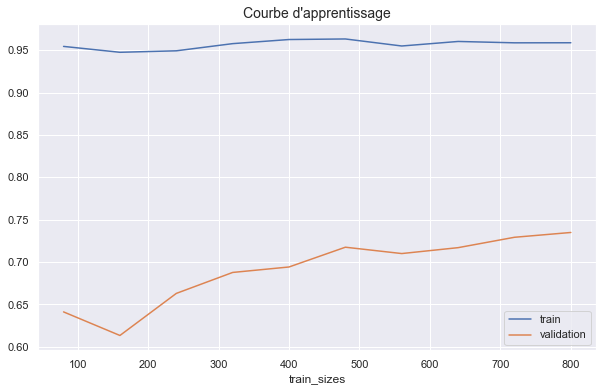

In [132]:
N,train_score,val_score = learning_curve(rfr,X_train,y_train,train_sizes = np.linspace(0.1,1.0,10))
plt.figure(figsize=(10, 6))
plt.plot(N,train_score.mean(axis=1),label='train')
plt.plot(N,val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.title("Courbe d'apprentissage", size = 14)
plt.legend()
plt.show()

#### Courbe de validation du modèle RandomForest

In [133]:
param_range = [50, 100, 150, 200, 250]  
train_scores, test_scores = validation_curve(
    rfr,  
    X_train, y_train,
    param_name="n_estimators",  
    param_range=param_range,
    cv=5,  
    scoring="r2",  
    n_jobs=-1  
)


In [134]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


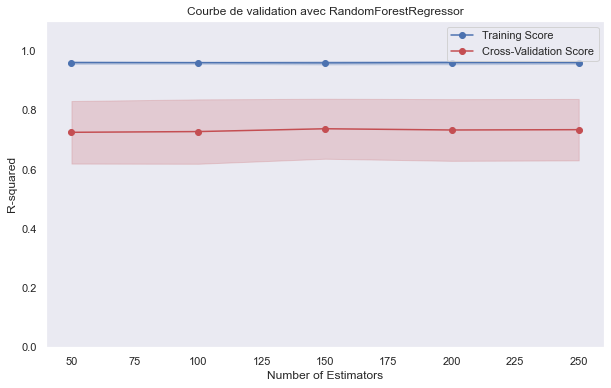

In [135]:
plt.figure(figsize=(10, 6))
plt.title("Courbe de validation avec RandomForestRegressor")
plt.xlabel("Number of Estimators")
plt.ylabel("R-squared")
plt.ylim(0.0, 1.1)
plt.grid()

plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="b")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="r")
plt.plot(param_range, train_scores_mean, 'o-', color="b", label="Training Score")
plt.plot(param_range, test_scores_mean, 'o-', color="r", label="Cross-Validation Score")

plt.legend(loc="best")
plt.show()


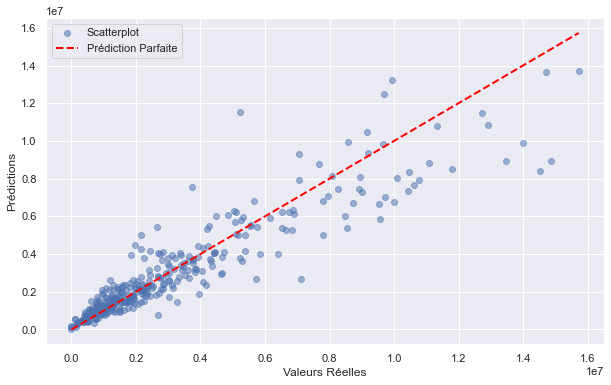

In [136]:
y_pred = rfr.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='b', label='Scatterplot')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--',
         linewidth=2, label='Prédiction Parfaite')
plt.xlabel('Valeurs Réelles')
plt.ylabel('Prédictions')
plt.legend(loc='upper left')

plt.show()


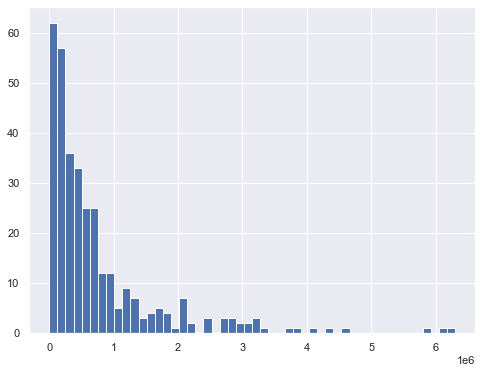

In [137]:
plt.figure(figsize=(8, 6))
y_pred = rfr.predict(X_test)
histo_erreur = np.abs(y_test - y_pred)
plt.hist(histo_erreur, bins= 50)
plt.show()

#### Courbe d'apprentissage du modèle GradientBoost

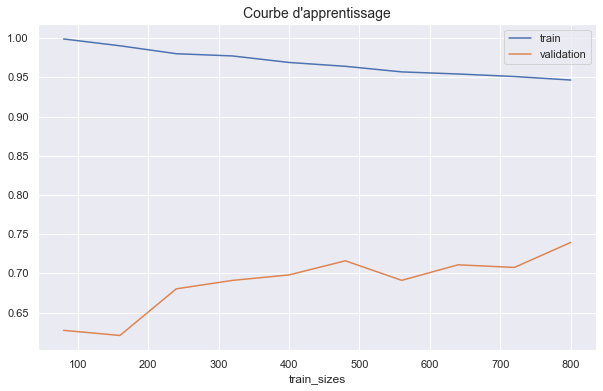

In [138]:
N,train_score,val_score = learning_curve(gboost,X_train,y_train,train_sizes = np.linspace(0.1,1.0,10))
plt.figure(figsize=(10, 6))
plt.plot(N,train_score.mean(axis=1),label='train')
plt.plot(N,val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.title("Courbe d'apprentissage", size = 14)
plt.legend()
plt.show()

#### Courbe de validation du modèle GradientBoost

In [139]:
param_range = [50, 100, 150, 200, 250]  
train_scores, test_scores = validation_curve(
    gboost,  
    X_train, y_train,
    param_name="n_estimators",  
    param_range=param_range,
    cv=5,  
    scoring="r2",  
    n_jobs=-1  
)


In [140]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


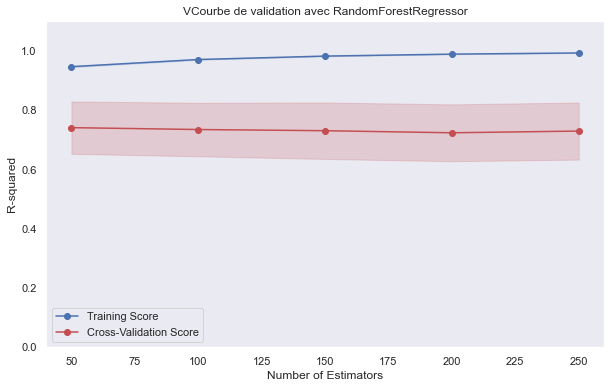

In [141]:
plt.figure(figsize=(10, 6))
plt.title("VCourbe de validation avec RandomForestRegressor")
plt.xlabel("Number of Estimators")
plt.ylabel("R-squared")
plt.ylim(0.0, 1.1)
plt.grid()

plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color="b")
plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.2, color="r")
plt.plot(param_range, train_scores_mean, 'o-', color="b", label="Training Score")
plt.plot(param_range, test_scores_mean, 'o-', color="r", label="Cross-Validation Score")

plt.legend(loc="best")
plt.show()


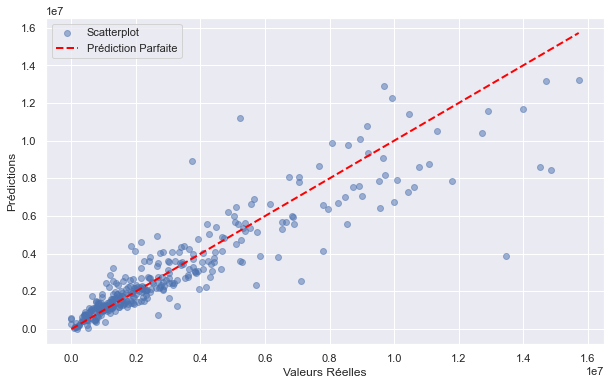

In [142]:
y_pred = gboost.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, color='b', label='Scatterplot')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--',
         linewidth=2, label='Prédiction Parfaite')
plt.xlabel('Valeurs Réelles')
plt.ylabel('Prédictions')
plt.legend(loc='upper left')

plt.show()


#### Features importance

In [143]:
feature_importance_rf = rfr.feature_importances_

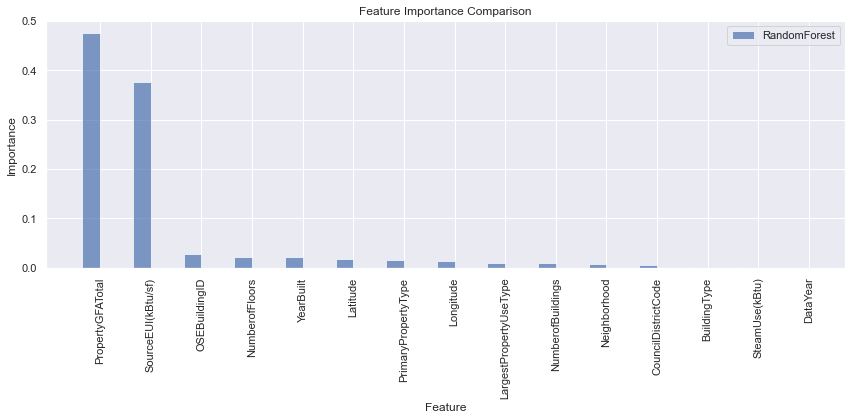

In [144]:
importance_df = pd.DataFrame({'Feature': X_train.columns, 'RandomForest': feature_importance_rf})

importance_df.sort_values(by='RandomForest', ascending=False, inplace=True)

bar_width = 0.35
index = np.arange(len(importance_df))

plt.figure(figsize=(12, 6))
plt.bar(index, importance_df['RandomForest'], bar_width, label='RandomForest', alpha=0.7)
plt.xticks(index + bar_width / 2, importance_df['Feature'], rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.legend()
plt.title('Feature Importance Comparison')
plt.tight_layout()
plt.show()

In [145]:
pd.Series(rfr.feature_importances_*100, index=X_train.columns).nlargest(20)

PropertyGFATotal          47.637218
SourceEUI(kBtu/sf)        37.543973
OSEBuildingID              2.704614
NumberofFloors             2.173011
YearBuilt                  2.137972
Latitude                   1.750812
PrimaryPropertyType        1.435053
Longitude                  1.303182
LargestPropertyUseType     0.985519
NumberofBuildings          0.911492
Neighborhood               0.776226
CouncilDistrictCode        0.511167
BuildingType               0.093377
SteamUse(kBtu)             0.036384
DataYear                   0.000000
dtype: float64

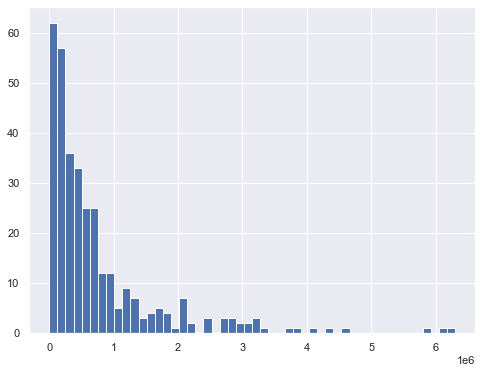

In [146]:
plt.figure(figsize=(8, 6))
y_pred = rfr.predict(X_test)
histo_erreur = np.abs(y_test - y_pred)
plt.hist(histo_erreur, bins= 50)
plt.show()

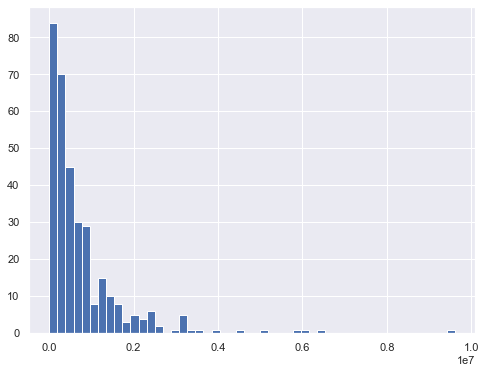

In [147]:
plt.figure(figsize=(8, 6))
y_pred = gboost.predict(X_test)
histo_erreur = np.abs(y_test - y_pred)
plt.hist(histo_erreur, bins= 50)
plt.show()